## Calculation of isotropic superconductivity

Author: S. Mishra (v1.1, 06/01/2024) <br>
Revision: S. Mishra (v1.2, 11/06/2024) <br>

In this notebook, we calculate the superconductivity properties of FCC Pb by solving the
isotropic Migdal-Eliashberg equations. The theory related to this tutorial can be found in 
[Phys. Rev. B **87**, 024505 (2013)](https://doi.org/10.1103/PhysRevB.87.024505). 

Electrons and phonons are computed with Quantum ESPRESSO (QE), maximally-localized Wannier functions are computed with Wannier90, and superconductivity is computed with EPW. Using EPW, we do the following:

1. We interpolate the electron-phonon matrix elements to fine **k** and **q** grids;
2. Solve the Migdal-Eliashberg equations ignoring the momentum dependence in the imaginary and real frequencies at different temperatures;
3. We also showed the nesting function and momentum dependence of electron-phonon coupling. 

In [1]:
import numpy as np
import time, sys, os
sys.path.insert(0,str(os.getcwd())+'/../')
from EPWpy import EPWpy
from EPWpy.plotting import plot_supercond
pathQE='/home/shashi-phy/codes/q-e/bin'
print(pathQE)

/home/shashi-phy/codes/q-e/bin


Below we define constants that will remail unchanged throughout the Notebook. The object `pb` is created as an instance of the `EPWpy` class. This object will contain everything that we need to execute and analyze the calculations.

#### Set paths to relevant directories:

In [2]:
prefix='pb'
pseudo='/home/shashi-phy/codes/epw_notebook/pseudos'
# Maximum number of cores to be used
cores = 4
print('Maximum number of cores to be used:', cores)

Maximum number of cores to be used: 4


#### Create Calculation Object

In [3]:
pb=EPWpy.EPWpy({ 'prefix':prefix,
            'calculation':'\'scf\'',
            'ibrav':2,
            'celldm(1)':'9.222558',
            'nat':1,
            'ntyp':1,
            'atomic_species':['Pb'],
            'atomic_pos':np.array([[0.0, 0.0, 0.0]]), 
            'atomic_position_type':'crystal', 
            'atoms':['Pb'],
            #'pseudo_auto':True,
            'pseudo':['pb_s.UPF'],
            'ecutwfc':'90',
            'ecutrho':'360',
            'smearing':'\'mp\'',
            'occupations':'\'smearing\'',
            'degauss':'0.025',
            'pseudo_dir':'\''+str(pseudo)+'\''},
            code=pathQE,
            env='mpirun',system = prefix)
#######Printing relevant info ######
pseudopot=pb.__dict__['pw_atomic_species']['pseudo'][0]
print('prefix:', pb.__dict__['pw_control']['prefix'])
print('pseudopotential:', pb.__dict__['pw_atomic_species']['pseudo'][0])
print('pseudopotential directory:', pb.__dict__['pw_control']['pseudo_dir'])
pb.run_serial= True
#app = pb.display_lattice(supercell=[2,2,1])
#app.run()


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

#### Self-consistent field (SCF) calculation

Here we perform the self-consistent field calculation to obtain the electron charge density of pb in the ground state. The calculation consists of three separate steps:
1. Apply the method `scf` to the object `pb`. This step specifies runtime parameters for an SCF calculation on pb
2. Based on the properties defined at step 1 as well as other properties that are set by default within EPWpy, the method `prepare` creates the input file needed by QE
3. The method `run` applied to the object `pb` instructs QE to perform the SCF calculation

In [4]:
pb.scf(name='scf', kpoints={'kpoints':[[14,14,14]]})
#####################################
pb.prepare(1,type_run='scf')
pb.run(cores)

-- -- -- -- -- -- -- -- -- -- --  Calculation: scf  -- -- -- -- -- -- -- -- -- -- -- 
Running scf |████████████████████████████████████████| in 38.1s (0.03/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Band Structure Calculation

We now calculate the band structure of the material.

The band structure is the eigenenergies of KS orbitals at various points in the Brillouin zone.
We choose a path that passes through all of the high symmetry $k$-points and plot along that.

$\Big(-\frac{\hbar^2}{2m}|k+G|^2+V_{KS}(G-G')\Big)\phi_v(k)=\epsilon_v(k)\phi_v(k)$ 

This calculation is not strictly necessary to compute the superconductivity, but it is useful to understand the electronic structure of the system under consideration.

In [5]:
pb.verbosity = 2
pb.scf(control={'calculation':'\'bands\''},
       kpoints=
            {'kpoints':[['0.000', '0.000', '0.000', '20'],
                        ['0.000', '0.500', '0.500', '20'],
                        ['0.250', '0.500', '0.750', '20'],
                        ['0.500', '0.500', '0.500', '20'],
                        ['0.375', '0.375', '0.750', '20'],
                        ['0.000', '0.000', '0.000', '20'],
                        ['0.500', '0.500', '0.500',  '1'],
                       ],'kpoints_type':'{crystal_b}'},
            name='bs')
########################################
pb.prepare(1,type_run='bs')
pb.run(cores,type_run='bs')

-- -- -- -- -- -- -- -- -- -- --  Calculation: bs  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/pw.x -nk 2 -nt 2 -in  bs.in > bs.out
Running bs |████████████████████████████████████████| in 31.3s (0.04/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [6]:
pb.bands(name='bands')
pb.prepare(1,type_run='bands')
# Running on too many cores will cause the job to fail
pb.run(4,type_run='bands')

-- -- -- -- -- -- -- -- -- -- --  Calculation: bands  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/bands.x -in bands.in > bands.out
Running bands |████████████████████████████████████████| in 0.7s (25.09/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Plotting band structure

The band structure is given in file `bands.dat` and plottable bands are written to `bands.dat.gnu` file, which
contains two columns.  The first column is the distance along the $k$-path, and the second column is the energies (eV). 
We will use this file for plotting as below.

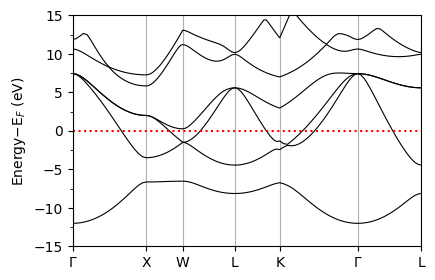

In [4]:
### Get the Fermi level
ef = plot_supercond.get_fermi(prefix)
xticks=['$\Gamma$','X', 'W', 'L', 'K', '$\Gamma$','L']
plot_supercond.band_plot(prefix, xticks)

#### Density of states (DOS) calculation using tetrahedra method

In [8]:
#pb.scf_fold='scf'
pb.scf(control={'calculation':'\'nscf\''},
        system={'nbnd':12, 'occupations':'\'tetrahedra\''},
        kpoints={'kpoints_type':'automatic',
                 'kpoints':[[14,14,14]]},
       name = 'nscf2')

pb.prepare(1,type_run='nscf2',infile = 'nscf2.in')
pb.run(cores,type_run='nscf2',infile = 'nscf2')

-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf2  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/pw.x -nk 2 -nt 2 -in  nscf2.in > nscf2.out
Running nscf2 |████████████████████████████████████████| in 31.9s (0.04/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [9]:
ef = plot_supercond.get_fermi(prefix)
pb.dos(dos={'prefix':prefix,
            'Emin':ef - 15,
            'Emax':ef + 15})
## Prepare folders and copy necessary files ##
pb.prepare(1,type_run='dos')
## Run calculation ##
pb.run(cores,type_run='dos')

-- -- -- -- -- -- -- -- -- -- --  Calculation: dos  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/dos.x -in dos.in > dos.out
Running dos |████████████████████████████████████████| in 16.0s (0.09/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Plotting the Band Structure and DOS

We now plot the band structure and DOS of the material (Pb in our case).

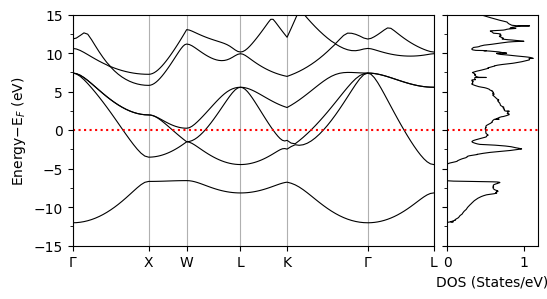

In [5]:
xticks=['$\Gamma$','X', 'W', 'L', 'K', '$\Gamma$','L']
plot_supercond.bandos_2plot(prefix, xticks)

### Phonon Calculation

In order to obtain the Eliashberg spectral function, we need the electron-phonon interactions, 
which are the first derivatives of the lattice potential with respect to the atomic displacements.
We also need the phonon energies and displacement vectors.
We obtain vibrational frequencies and eigenmodes using the density functional perturbation theory [(DFPT)](https://link.aps.org/doi/10.1103/RevModPhys.73.515) 
1. We compute these properties on a uniform and $\Gamma$ centered Brillouin zone grid
2. We perform a Fourier transform of the results in order to obtain the interatomic force constants (IFCs)
3. We interpolate the IFCs along specified Brillouin zone paths to obtain phonon dispersions.

This plot of phonon dispersions is only meant to develop a qualitative understanding of the vibrational properties of the system under consideration. 
The phonon interpolation needed for calculations of the Eliashberg spectral function is performed later by EPW.

##### Step 1: Calculations of phonons on uniform Brillouin zone grid

In [15]:
pb.ph(phonons={'fildyn':'\'pb.dyn\'',
                    'nq1':3,
                    'nq2':3,
                    'nq3':3,
                    'fildvscf':'\'dvscf\''}
          )
pb.prepare(1,type_run='ph')
pb.run(cores, type_run='ph')

-- -- -- -- -- -- -- -- -- -- --  Calculation: ph  -- -- -- -- -- -- -- -- -- -- -- 
Running ph |████████████████████████████████████████| in 0.0s (6241.14/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


##### Step 2: Interatomic Force Constant (IFC) Calculation

We evaluate the interatomic force constants obtained via second derivatives of the total potential energy, 
that is: $C_{\kappa\alpha\rho\kappa'\alpha'\rho'}=\frac{\partial^{2}Ua}{\partial\tau_{\kappa\alpha\rho}\tau_{\kappa'\alpha'\rho'}}$

In [16]:
pb.q2r(q2r={'fildyn':'\'pb.dyn\'',
            'flfrc':'\'pb.fc\''})
pb.prepare(1,type_run='q2r')
pb.run(1,type_run='q2r')

-- -- -- -- -- -- -- -- -- -- --  Calculation: q2r  -- -- -- -- -- -- -- -- -- -- -- 
Running q2r |████████████████████████████████████████| in 0.1s (1318.29/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


##### Step 3: Phonon Dispersion Calculation

In [8]:
#### matdyn calculation (real space force constant) #####
pb.scf_fold='scf'
pb.ph_fold='ph'
pb.matdyn(name='matdyn',
          matdyn={'flfrq':'\''+str(prefix)+'.freq\'', 
                  'flfrc':'\''+str(prefix)+'.fc\''},
          kpoints={'kpoints':[['0.0', '0.0', '0.0', '20'],
                              ['0.0', '0.5', '0.5', '20'],
                              ['0.25', '0.5', '0.75', '20'],
                              ['0.5','0.5','0.5','20'],
                              ['0.375','0.375','0.75','20'],
                              ['0.0', '0.0', '0.0', '20'],
                              ['0.5', '0.5', '0.5', '1']]})
## Prepare folders and copy necessary files ##
pb.prepare(1,type_run='matdyn')
## Run calculation ##
pb.run(1,type_run='matdyn')

-- -- -- -- -- -- -- -- -- -- --  Calculation: matdyn  -- -- -- -- -- -- -- -- -- -- -- 
Running matdyn |████████████████████████████████████████| in 0.5s (38.98/s)     

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


##### Phonon DOS Calculation

In [9]:
pb.phdos(name='phdos',
          phdos={'flfrq':'\''+str(prefix)+'.dos.freq\'', 
                  'flfrc':'\''+str(prefix)+'.fc\'',
                  'fldos':'\''+str(prefix)+'.dos\'',
                  'dos':'.true.',
                  'nk1':12,
                  'nk2':12,
                  'nk3':12,})
## Prepare folders and copy necessary files ##
pb.prepare(1,type_run='phdos')
## Run calculation ##
pb.run(cores, type_run='phdos')

-- -- -- -- -- -- -- -- -- -- --  Calculation: phdos  -- -- -- -- -- -- -- -- -- -- -- 
Running phdos |████████████████████████████████████████| in 0.6s (28.67/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


##### Plotting Phonon Dispersion and DOS

Plot saved as: pb_phonons.pdf


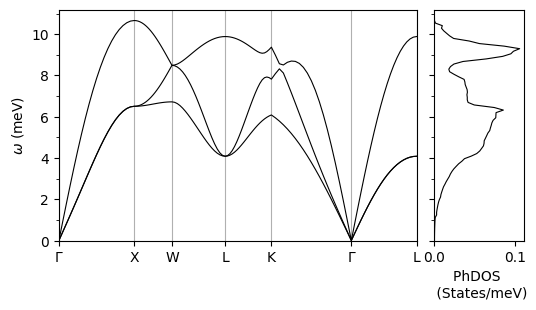

In [8]:
xticks=['$\Gamma$','X', 'W', 'L', 'K', '$\Gamma$','L']
plot_supercond.phonon_plot(prefix, xticks)

### Transformation of electrons and phonons to Wannier basis with EPW

Now we have Kohn-Sham wavefunctions and variations of the self-consistent Kohn-Sham potential on coarse Brillouin zone grid. We will generate the electron Hamiltonian, the IFCs, and the electron-phonon matrix elements in the Wannier representation using [EPW](https://epw-code.org/). Details on the underlying formalism can be found [here](https://arxiv.org/abs/1603.06965) (free version) or [here](https://doi.org/10.1103/RevModPhys.89.015003) (journal version).

This operation involves four logical steps:
1. Compute Kohn-Sham states on a uniform $\Gamma$ centered Brillouin zone grid (QE) between [0, 1] in crystal coordinates 
2. Use EPW to load these states and call Wannier90 to generate Wannier functions
3. Use EPW to load IFCs (or dynamical matrices) and potential variations, and combine with step 2 to compute electron-phonon matrix elements in the Bloch representation
4. Use EPW to perform the transformation to the Wannier basis and write to file

##### Step 1: Calculations of Kohn-Sham states on uniform Brillouin zone grid

In [6]:
#pb.scf_fold='scf'
pb.nscf(control={'calculation':'\'bands\''}, 
        system={'nbnd':10,
                'occupations':'\'smearing\'',
                'smearing':'\'mp\'',
                'degauss':'0.025'},
        kpoints={'grid':[3,3,3],'kpoints_type': 'crystal'})
pb.prepare(4,type_run='nscf')
pb.run(cores, type_run='nscf')

-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf  -- -- -- -- -- -- -- -- -- -- -- 
Running nscf |████████████████████████████████████████| in 7.4s (0.20/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


##### Steps 2-4: Load Bloch representation, Wannierize, write to file quantities in Wannier representation

Now, we have the phonon spectra, the dynamical matrix elements, and the electron-phonon interactions as discussed in the [RMP paper](https://link.aps.org/doi/10.1103/RevModPhys.89.015003).
We interpolate dynamical matrix elements, and the electron-phonon coupling matrices using the [EPW code](https://www.sciencedirect.com/science/article/pii/S0010465516302260). 

In [4]:
#pb.run_serial = True
#pb.reset() # SM: Show error 
pb.nscf_file='scf'
pb.scf_fold='scf'
pb.nscf_file='nscf'
pb.nscf_fold='nscf'
pb.ph_file='ph'
pb.ph_fold='ph'
pb.verbosity = 2

pb.filkf_file = 'pb.kpath.txt'

# EPW run 1: Bloch to Wannier
pb.epw(epwin={'wdata':['guiding_centres = .true.',
                       'dis_num_iter = 300',
                       'num_print_cycles  = 10',
                       'dis_mix_ratio = 1',
                       'use_ws_distance = T'],
                      'proj':['\'Pb : sp3\''],
                      'dis_froz_min':-3,
                      'dis_froz_max':13.5,
                      'bands_skipped':'\'exclude_bands=1:5\'',
                      'nbndsub':4,
                      'etf_mem':0, 
                      'num_iter':300, 
                      'elph':'.true.',
                      'band_plot':'.true.',
                      'filkf':pb.filkf_file,
                      'filqf':pb.filkf_file
                       },name='epw1')

pb.prepare(4,type_run='epw1') 
pb.run(cores, type_run='epw1')

(4, 3)
[51, 51, 51]
User-provided filkf: pb.kpath.txt
Using user-defined filkf file: pb.kpath.txt
Using user-defined filqf file: pb.kpath.txt
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw1  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/epw.x -nk 4 -in  epw1.in > epw1.out
Running epw1 |████████████████████████████████████████| in 32.0s (0.04/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Sanity check: Interpolated bands and phonons from EPW

At this point we have all necessary quantities in the Wannier representation on file. As a sanity check, we perform a simple interpolation of bands and phonons to make sure that we reproduce the results found above _without_ Wannier interpolation.

In [6]:
pb.plotband(name='plotband')
pb.prepare(1,type_run='plotband')
pb.run(1,type_run='plotband')

-- -- -- -- -- -- -- -- -- -- --  Calculation: plotband  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 1 /home/shashi-phy/codes/q-e/bin/plotband.x <  plotband.in > plotband.out
Running plotband |████████████████████████████████████████| in 0.1s (1764.68/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Plot saved as: pb_band.pdf


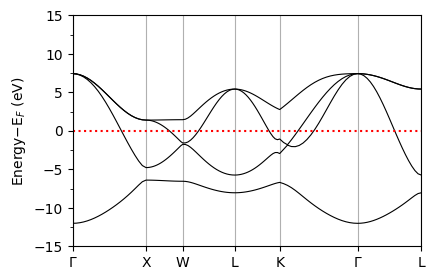

In [7]:
#ef = plot_supercond.get_fermi(prefix)
xticks=['$\Gamma$','X', 'W', 'L', 'K', '$\Gamma$','L']
sym_file = './pb/epw/plotband.out'  # Path to high-symmetry points file
band_file = './pb/epw/band.dat'    # Path to band structure data file
plot_supercond.band_plot(prefix, xticks, band_file=band_file, sym_file=sym_file)

In [8]:
#Generate phonon interpolated band
pb.plotband(['phband.freq', '0 50', 'phband.dat']
            ,name='plotband')
pb.prepare(1,type_run='plotband')
pb.run(1, type_run='plotband')

-- -- -- -- -- -- -- -- -- -- --  Calculation: plotband  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 1 /home/shashi-phy/codes/q-e/bin/plotband.x <  plotband.in > plotband.out
Running plotband |████████████████████████████████████████| in 0.1s (2532.32/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Reading data from: ./pb/epw/phband.dat
Plot saved as: pb_phonon_dispersion.pdf


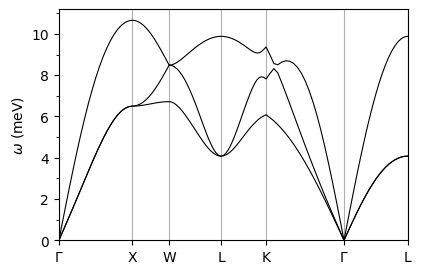

Reading data from: ./pb/ph/pb.freq.gp
Plot saved as: pb_phonon_dispersion.pdf


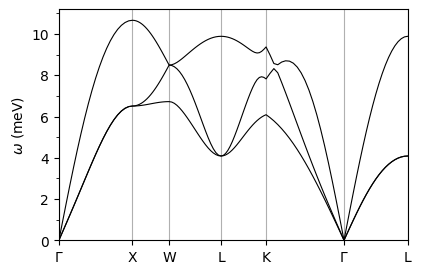

In [9]:
xticks=['$\Gamma$','X', 'W', 'L', 'K', '$\Gamma$','L']

plot_supercond.phband_plot(prefix, xticks, band_file='./pb/epw/phband.dat',sym_file='./pb/epw/plotband.out')
plot_supercond.phband_plot(prefix, xticks, band_file='./pb/ph/pb.freq.gp',sym_file='./pb/bs/bands.out')

#### Superconductivity Calculations

To compute the superconducting properties, we perform the following operations:
1. We interpolate the electrons, phonons, and electron-phonon couplings from coarse $3 \times 3 \times 3$ to dense $18 \times 18 \times 18$  $k$- and $q$-point grids.
2. We use the interpolated e-ph couplings to solve the Eliashberg expressions. 
Both steps are performed within a single call of EPW. Brief discussions of inputs are explained below.

- Pre-compute the $q$-points that fall within the Fermi window `fsthick`. If, at a specific $q$-point, at least one $k+q$ eigenenergy falls within `fsthick` of the Fermi level, then the $q$-point is selected.

- The calculation of superconductivity properties is accompanied by setting `ephwrite = .true.`. The files are unformatted and 
    are required for solving the Migdal-Eliashberg equations.
    
Now, we solve the isotropic Migdal-Eliashberg equations on the imaginary frequency axis. This is achieved by setting the keywords `eliashberg = .true.`, `liso = .true.`, and 
`limag = .true.` in the input file. The equations are solved self-consistently for each temperature 
specified in `temps`. The calculation  at each temperature ends when either the 
converge threshold or the maximum number of iterations is reached.

The isotropic electron-phonon coupling strength is expressed as follows
$$
\lambda(\omega_j) = \sum_{n} \int \frac{dk}{\Omega_{\rm BZ}}\frac{\delta(\varepsilon_{nk}-\varepsilon_F)}{N_F} \lambda_{nk}(\omega_j) 
$$

The isotropic Migdal-Eliashberg equations take the following form:
    
$$Z(i\omega_j) = 1 + \frac{\pi T}{\omega_j} \sum_{j^\prime} 
           \frac{  \omega_j^\prime}{ \sqrt{{\omega_j^\prime}^2 + \Delta(i\omega_{j^\prime})}} \lambda(\omega_j-\omega_{j^\prime})$$

$$Z(i\omega_j) \Delta(i\omega_j) = \pi T \sum_{j^\prime} 
\frac{ \Delta(i\omega_j^\prime) }{ \sqrt{{\omega_{j^\prime}}^2 + \Delta(i\omega_{j^\prime})} }\left[ \lambda(\omega_j-\omega_{j^\prime}) - \mu^* \right]$$

The semiempirical Coulomb parameter $\mu^*$ is provided as an input variable `muc` in the EPW 
calculation. The isotropic electron-phonon coupling strength $\lambda(\omega_j)$ is defined as:

$$\lambda(\omega_j) = \frac{1}{N_F} \sum_{n m \nu} \int \frac{dk} {\Omega_{\rm BZ}} \int \frac{dq}{\Omega_{\rm BZ}}\left|g_{mn\nu}(k,q)\right|^2 \frac{2\omega_{q\nu}}{\omega_j^2+\omega_{q\nu}^2}\delta(\varepsilon_{nk}-\varepsilon_F) \delta(\varepsilon_{mk+q}-\varepsilon_F)$$

- Eliashberg spectral function and integrated electron-phonon coupling strength ($\lambda$).

- The `pb.a2f` and `pb.a2f_proj` files are generated by setting `eliashberg = .true.`

  - The `pb.a2f` file contains the isotropic Eliashberg spectral function $\alpha^2F(\omega)$ and the cumulative
electron-phonon coupling strength $\lambda$ as a function of frequency $\omega$(meV) for different phonon smearing values. 

  - The `pb.a2f_proj` file contains the Eliashberg spectral function  as a function of frequency $\omega$(meV), 
where the 2nd column is the Eliashberg spectral function corresponding to the first smearing in `pb.a2f`. 
The remaining (3$\times$number of atoms) columns contain the mode-resolved Eliashberg spectral functions corresponding to the first smearing in 
`pb.a2f`.  There is no specific information on which modes correspond to which atomic species.

- Superconducting gap along the imaginary frequency axis and the real frequency axis.
 
  - `pb.imag_iso_XX` files are generated by setting `eliashberg = .true.`, `liso = .true.`, and 
    `limag = .true.`. Each file contains 3 columns: the Matsubara frequency $i\omega_j$ (eV) along the 
    imaginary axis, the quasiparticle renormalization function $Z(i\omega_j)$, and the superconducting gap 
    $\Delta(i\omega_j)$ (eV). 

 - `pb.pade_iso_XX` files are generated by setting `lpade = .true.`. Each file contains 5 columns: 
    the frequency $\omega$ (eV) along the real axis, the real part of the quasiparticle renormalization 
    function ${\rm Re}Z(\omega)$, the imaginary part of the quasiparticle renormalization function ${\rm Im}Z(\omega)$, the real 
    part of the superconducting gap ${\rm Re}\Delta(\omega)$ (eV), and the imaginary part of the superconducting 
    gap ${\rm Im}\Delta(\omega)$ (eV).  

In [10]:
#pb.reset()
#pb.nscf_file='scf'
#pb.scf_fold='scf'
#pb.nscf_file='nscf'
#pb.nscf_fold='nscf'
#pb.ph_file='ph'
#pb.ph_fold='ph'
#pb.epw_fold='epw'
pb.verbosity = 2
pb.epw(epwin={'elph':'.true.',                       
                   'etf_mem': '0',
                   'nkf1':18,   
                   'nkf2':18,   
                   'nkf3':18,
                   'nqf1':18,
                   'nqf2':18,
                   'nqf3':18,    
                   'mp_mesh_k':'.true.',
                   'fsthick': 0.4,
                   'temps':'0.3 0.9 1.5 2.1 2.7 3.3 3.9 4.0 4.2 4.4 4.5 4.6',
                   'degaussw':0.1, 
                  'ephwrite':'.true.',
                  'eliashberg':'.true.',
                  'liso':'.true.',
                  'limag':'.true.',
                  'lpade':'.true.',
                  'nsiter': '500',
                  'broyden_beta': -0.3,
                  'npade':'20',
                  'wscut' :'0.1', 
                  'muc':'0.1',
                  'clean_supercond':None},
            name='epw2')
pb.prepare(4,type_run='epw2')
pb.run(cores,type_run='epw2')

-- -- -- -- -- -- -- -- -- -- --  Calculation: epw2  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/epw.x -nk 4 -in  epw2.in > epw2.out
Running epw2 |████████████████████████████████████████| in 17.0s (0.08/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Plot saved as: pb_a2f_plot.pdf


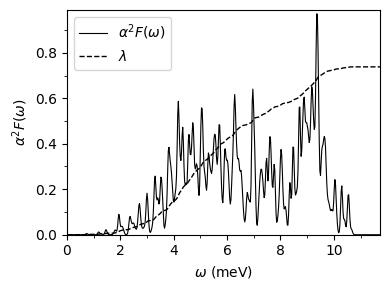

In [11]:
plot_supercond.plot_a2f(prefix)

##### Superconducting gap $\Delta$ along the imaginary and real frequency axis

Plot saved as: /home/shashi-phy/codes/epw_notebook/notebooks_basic/pb_iso_gap_real_imag.pdf


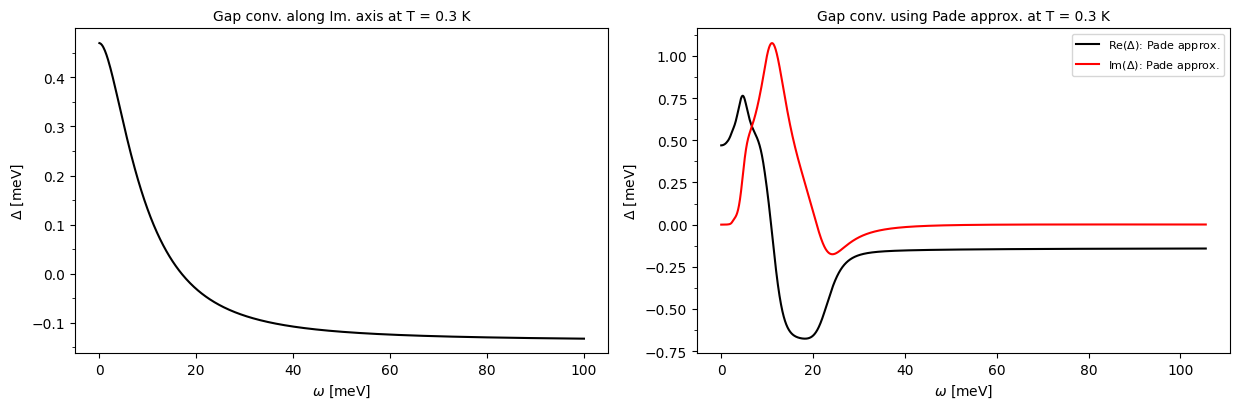

In [5]:
plot_supercond.gap_iso_real_imag_conv(prefix, temp=0.3)

#### Plotting Superconducting Gap as a Function of Temperature


Plot saved as: ./pb_iso_gap_real_imag_vs_Temp.pdf


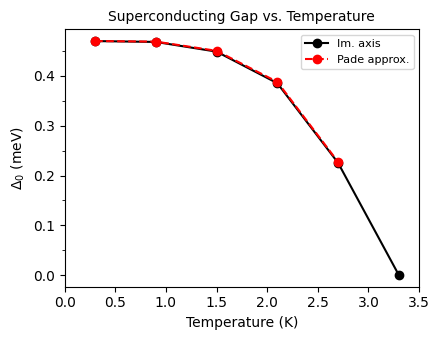

In [6]:
#maximum temperature
tempmax = 3.5
plot_supercond.gap_iso_real_imag_temp(prefix, tempmax, font=10)

Plot saved as: /home/shashi-phy/codes/epw_notebook/notebooks_basic/pb_iso_gap_imag_vs_Temp.pdf


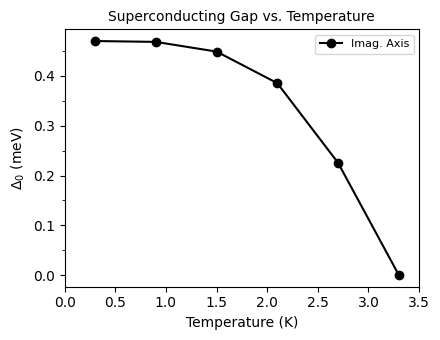

In [7]:
tempmax = 3.5
plot_supercond.gap_iso_imag_temp(prefix, tempmax, font=10)

#### Critical Temperature Calculation using the Migdal-Eliashberg Equation

Near $T_c$, $\Delta(i\omega_j) \rightarrow 0$ and the Migdal-Eliasberg equations reduce to a linear matrix equation for $\Delta(i\omega_j)$:

$$\Delta(i\omega_j) = \sum_{j^\prime} K_{jj^\prime}\Delta(i\omega_{j^\prime})$$

where 
$$
K_{jj^\prime} = \frac{1}{|2 j^\prime+1|} \left[ \lambda(\omega_j-\omega_{j^\prime})-\mu^*  - \delta_{j j^\prime} \sum_{j''}  \lambda(\omega_j-\omega_{j''}) s_j s_{j''} \right]$$
and $s_j = sign(\omega_j)$. The critical temperature $T_c$ is defined as the value at which the maximum eigenvalue of $K_{jj^\prime}$ is 1.

This step can be done by starting from a file containing the Eliashberg spectral function `pb.a2f_iso` as shown below.

In [12]:
pb.epw(epwin={'elph':'.false.',
              'ephwrite':'.false.',
              'fila2f': 'pb.a2f', 
              'tc_linear':'.true.', 
              'tc_linear_solver':'power', 
              'nstemp': 21, 
              'temps': '0.25 5.25', 
              'wscut' :'0.1', 
              'muc':'0.1',
              'eliashberg':'.true.',
              'liso':'.true.',
              'limag':'.true.',
              'nsiter': '500',
              'broyden_beta': '-0.7',
              'conv_thr_iaxis':'1.0d-3',
              'nkf1':18,'nkf2':18,'nkf3':18,
              'nqf1':18,'nqf2':18,'nqf3':18,
              'mp_mesh_k':'.true.',
              'clean_supercond':None},
              name='epw3')

##############################################
pb.prepare(4,type_run='epw3')
pb.run(cores, type_run='epw3')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw3  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/epw.x -nk 4 -in  epw3.in > epw3.out
Running epw3 |████████████████████████████████████████| in 4.2s (0.39/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Calculated maximum eigenvalue as a function of temperature.

Plot saved as: ./pb_max_eig_value_vs_Temp.pdf


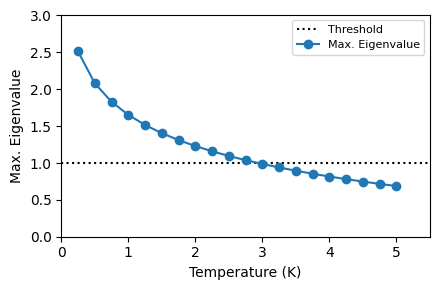

In [13]:
tempmax = 5.0
plot_supercond.max_eig_temp(prefix, 'epw3.out')

#### Full-Bandwidth (FBW) Isotropic Calculation

Up to now, we have solved the Migdal-Eliashberg equations in the so-called Fermi surface restricted (FSR) approximation by restricting the summations only to states in an energy range close to the Fermi level. In this approach, it is assumed that the DOS within this energy window is constant. In materials where the DOS at the Fermi level varies significantly, one can instead solve the Migdal-Eliashberg equations in the full-bandwidth (FBW) approximation. In this case, the electronic states are not restricted to the vicinity of the Fermi surface. The isotropic FBW Eliashberg expression can be written as follows:

$$Z(i{\omega }_{j})=\,1+\frac{{k}_{{{{\rm{B}}}}}T}{N({\varepsilon }_{{{{\rm{F}}}}}){\omega }_{j}}\int\,{\rm {d}}\varepsilon N(\varepsilon )\mathop{\sum}\limits_{{j}^{{\prime} }}\frac{{\omega }_{{j}^{{\prime} }}Z(i{\omega }_{{j}^{{\prime} }})}{\theta (\varepsilon ,i{\omega }_{{j}^{{\prime} }})}\lambda ({\omega }_{j}-{\omega }_{{j}^{{\prime} }})$$

$$\chi (i{\omega }_{j})=\,-\frac{{k}_{{{{\rm{B}}}}}T}{N({\varepsilon }_{{{{\rm{F}}}}})}\int\,{\rm {d}}\varepsilon N(\varepsilon )\mathop{\sum}\limits_{{j}^{{\prime} }}\frac{\varepsilon -{\mu }_{{{{\rm{F}}}}}+\chi (i{\omega }_{{j}^{{\prime} }})}{\theta (\varepsilon ,i{\omega }_{{j}^{{\prime} }})}\lambda ({\omega }_{j}-{\omega }_{{j}^{{\prime} }}),$$

$$\phi (i{\omega }_{j})=\,\frac{{k}_{{{{\rm{B}}}}}T}{N({\varepsilon }_{{{{\rm{F}}}}})}\int\,{\rm {d}}\varepsilon N(\varepsilon )\mathop{\sum}\limits_{{j}^{{\prime} }}\frac{\phi (i{\omega }_{{j}^{{\prime} }})}{\theta (\varepsilon ,i{\omega }_{{j}^{{\prime} }})}\left[\lambda ({\omega }_{j}-{\omega }_{{j}^{{\prime} }})-{\mu }_{{\rm {c}}}^{* }\right],$$

$${N}_{{{{\rm{e}}}}}=\,\int\,{\rm {d}}\varepsilon N(\varepsilon )\left[1-2{k}_{{{{\rm{B}}}}}T\mathop{\sum}\limits_{j}\frac{\varepsilon -{\mu }_{{{{\rm{F}}}}}+\chi (i{\omega }_{j})}{\theta (\varepsilon ,i{\omega }_{j})}\right],$$

where $$\theta (\varepsilon ,i{\omega }_{j})={\left[\hslash {\omega }_{j}Z(i{\omega }_{j})\right]}^{2}+{\left[\varepsilon -{\mu }_{{{{\rm{F}}}}}+\chi (i{\omega }_{j})\right]}^{2}+{\left[\phi (i{\omega }_{j})\right]}^{2}.$$

Here, ${N({\varepsilon }_{{{{\rm{F}}}}})}$ is the density of states (DOS) per spin at the Fermi level, ${\mu }_{{{{\rm{F}}}}}$ is the chemical potential, and ${N}_{{{{\rm{e}}}}}$ is the number of electrons per unit cell. 


The theory can be found in [Npj. Comm. Mat. **87**, 156 (2023)](https://www.nature.com/articles/s41524-023-01107-3).

Now, we will perform the FBW isotropic calculation for Pb. The `ephmatf` files will be the same as that of the 
FSR approximation. So, we need to solve the Superconducting gap along the imaginary frequency axis by setting
`eliashberg = .true.`, `liso = .true.`, `limag = .true.`, and `fbw = .true.`. 

Each file contains 4 columns: the Matsubara frequency $i\omega_j$ (eV) along the imaginary axis, the quasiparticle 
renormalization function $Z(i\omega_j)$, the energy shift $\chi(i\omega_j)$, and the superconducting gap $\Delta(i\omega_j)$ (eV). 

In [14]:
pb.epw(epwin={'fila2f': 'pb.a2f', 
              'eliashberg':'.true.',
              'liso':'.true.',
              'limag':'.true.',
              'fbw':'.true.', 
              'nstemp': 15, 
              'temps': '0.5 5.25', 
              'wscut' :'0.1', 
              'muc':'0.1',
              'nsiter': '500',
              'broyden_beta': '-0.7',
              'conv_thr_iaxis':'1.0d-3',
              'nkf1':18,'nkf2':18,'nkf3':18,
              'nqf1':18,'nqf2':18,'nqf3':18,
              'mp_mesh_k':'.true.'},name='epw3')
##############################################
pb.prepare(4,type_run='epw3')
pb.run(cores, type_run='epw3')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw3  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/epw.x -nk 4 -in  epw3.in > epw3.out
Running epw3 |████████████████████████████████████████| in 0.4s (56.78/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Plot saved as: /home/shashi-phy/codes/epw_notebook/notebooks_basic/pb_iso_FBW_gap_imag_vs_Temp.pdf


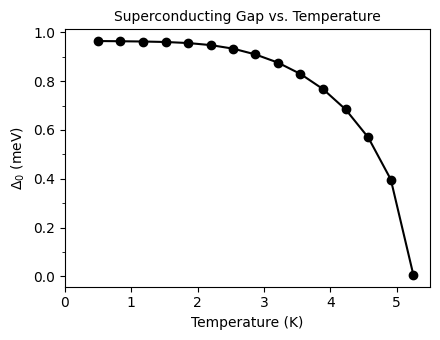

In [15]:
tempmax = 5.5
plot_supercond.gap_iso_imag_fbw(prefix, tempmax, font=10)

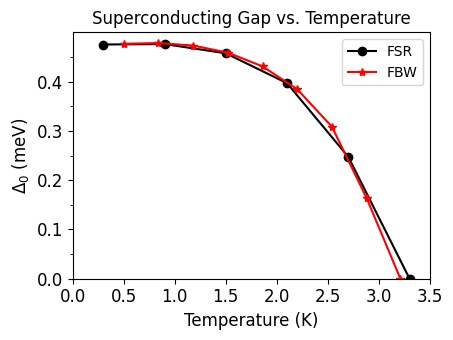

In [18]:
tempmax = 3.5
plot_supercond.gap_iso_fsr_and_fbw(prefix, home, tempmax, font=12)

#### Isotropic FBW+$\mu$ calculations

We can also update the chemical potential $\mu$ while solving the Eliashberg expression by setting `muchem=.true.`.

In [16]:
######## Write fbw+mu file ####################
pb.epw(epwin={'fila2f': 'pb.a2f', 
              'eliashberg':'.true.',
              'liso':'.true.',
              'limag':'.true.',
              'fbw':'.true.', 
              'nstemp': 15, 
              'temps': '0.5 5.25', 
              'wscut' :'0.1', 
              'muc':'0.1',
              'nsiter': '500',
              'broyden_beta': '-0.7',
              'conv_thr_iaxis':'1.0d-3',
              'nkf1':18,'nkf2':18,'nkf3':18,
              'nqf1':18,'nqf2':18,'nqf3':18,
              'mp_mesh_k':'.true.'},name='epw3')
##############################################
pb.prepare(4,type_run='epw3')
pb.run(cores, type_run='epw3')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw3  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/epw.x -nk 4 -in  epw3.in > epw3.out
Running epw3 |████████████████████████████████████████| in 0.4s (47.34/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Nesting function calculation ####

Compute the nesting function $f_{\mathrm{nest}}(\mathbf{q})$ as well as the electron-phonon coupling strength of each phonon $\lambda_{\mathbf{q}\nu}$ along the $\mathbf{q}$-point path using the following expressions [Phys. Rev. B **82**, 184509 (2010)](https://link.aps.org/doi/10.1103/PhysRevB.82.184509) 

$$f_{\mathrm{nest}}(\mathbf{q}) = \sum_{n m} \int \frac{d\mathbf{k}} {\Omega_{\rm BZ}} \delta(\epsilon_{n\mathbf{k}}-\epsilon_F) \delta(\epsilon_{m\mathbf{k}+\mathbf{q}}-\epsilon_F)$$

Within the double delta approximation `delta_approx = .true.`, the electron-phonon coupling strength of each phonon $\lambda_{\mathbf{q}\nu}$ is defined as follows:
$$\lambda_{\mathbf{q}\nu} = \frac{2}{N_F} \sum_{n m} \int \frac{d\mathbf{k}} {\Omega_{\rm BZ}} \frac{\left|g_{mn\nu}(\mathbf{k}, \mathbf{q})\right|^2}{\omega_{\mathbf{q}\nu}} \delta(\epsilon_{n\mathbf{k}}-\epsilon_F) \delta(\epsilon_{m\mathbf{k}+\mathbf{q}}-\epsilon_F)$$

To calculate these quantities, do an EPW calculation along the $\mathbf{q}$-point path specified by `filqf` using the function (`get_qpath`) and input file (`phselfen.in` and `nesting.in` files are shown below).

In [17]:
# Call the function to generate the q-path
plot_supercond.get_qpath(prefix)

File pb/ph/pb_band.kpt has been created successfully.


In [18]:
######## Phonon self-energy calculation ####################
pb.filqf_file = 'pb.kpath.txt'
pb.epw(epwin={'elph':'.true.',
              'nbndsub': 4,
              'fsthick':0.4, 
              'degaussw':0.1,
              'degaussq':0.5, 
              'phonselfen' : '.true.',
              'delta_approx':'.true.',
              'nkf1':18,'nkf2':18,'nkf3':18,
              'filqf': 'pb.kpath.txt'},
               name='epw3')
##############################################
pb.prepare(4,type_run='epw3')
pb.run(cores, type_run='epw3')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw3  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/epw.x -nk 4 -in  epw3.in > epw3.out
Running epw3 |████████████████████████████████████████| in 4.4s (0.36/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [19]:
######## Nesting function calculation ####################
pb.filqf_file = 'pb.kpath.txt'
pb.epw(epwin={'elph':'.true.',
              'nbndsub': 4,
              'fsthick':0.4, 
              'degaussw':0.1,
              'degaussq':0.5, 
              'nest_fn' : '.true.',
              'nkf1':18,'nkf2':18,'nkf3':18,
              'filqf': 'pb.kpath.txt'},
               name='epw3')
##############################################
pb.prepare(4,type_run='epw3')
pb.run(cores, type_run='epw3')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw3  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /home/shashi-phy/codes/q-e/bin/epw.x -nk 4 -in  epw3.in > epw3.out
Running epw3 |████████████████████████████████████████| in 4.6s (0.35/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


The default temperature is 1 K, so $\lambda_{\mathbf{q}\nu}$ is output for 1K. However, as long as the double delta approximation is applied, $\lambda_{\mathbf{q}\nu}$ does not depend on temperature. $\lambda_{\mathbf{q}\nu}$ is output in `lambda.phself.1.000K`.

Similarly, we get the nesting function in `nesting.out` for each $\mathbf{q}$ point.

In [4]:
# Call the function to extract and save nesting funtion data to pb.nesting_fn file
plot_supercond.extract_nesting(prefix, input_file='pb/epw/epw3.out')

Plot saved as: ./pb_nesting.pdf


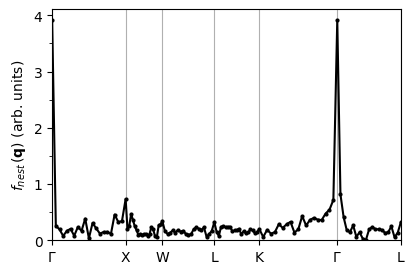

In [4]:
# plot the nesting function along the high-symmetry path
xticks=['$\Gamma$','X', 'W', 'L', 'K', '$\Gamma$','L']
sym_file='./pb/epw/plotband.out'
plot_supercond.nesting_plot(prefix, xticks, nestData='pb/epw/pb.nesting_fn', sym_file=sym_file)

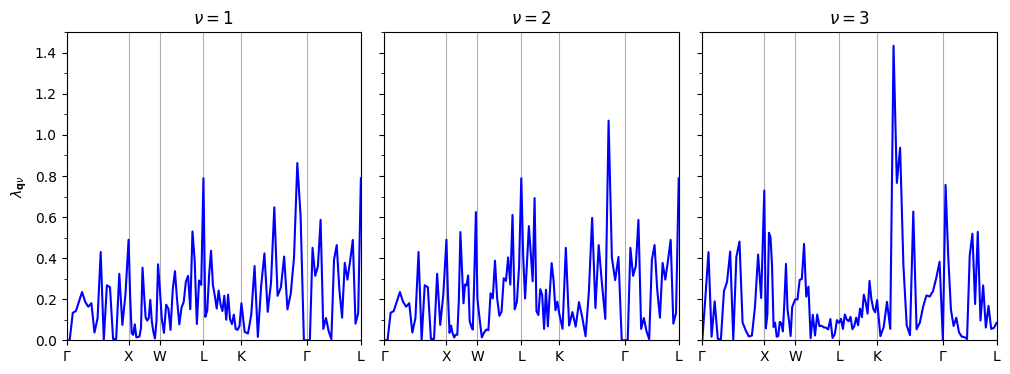

In [12]:
## plot the electron-phonon coupling along the q-path
xticks=['$\Gamma$','X', 'W', 'L', 'K', '$\Gamma$','L']
plot_supercond.lambdaq_plot(prefix, xticks, temps=300)

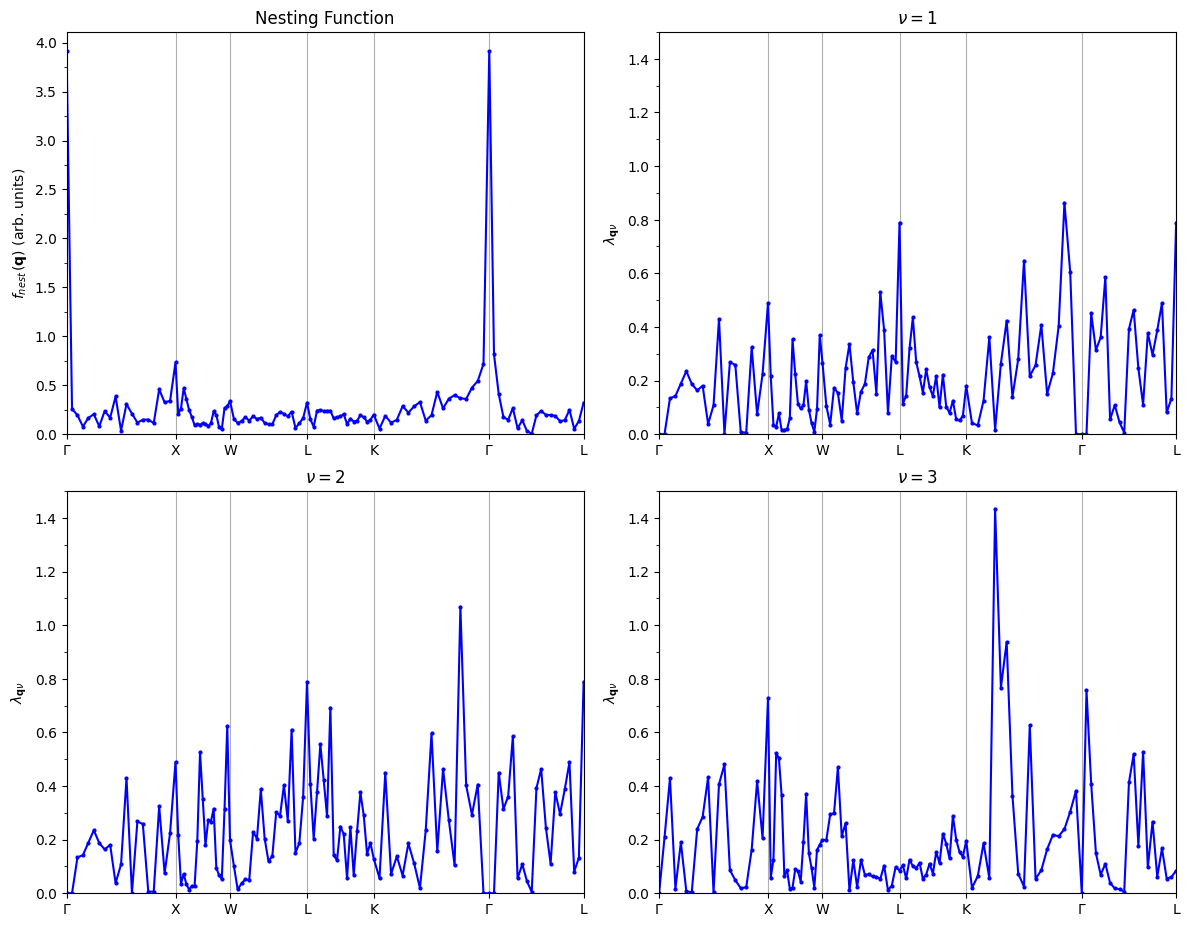

In [13]:
## plot the electron-phonon coupling along the q-path
xticks=['$\Gamma$','X', 'W', 'L', 'K', '$\Gamma$','L']
plot_supercond.combined_plot(prefix, xticks, temps=300)